<a href="https://colab.research.google.com/github/ProAek11/StrategyTradingFrendersis-AI-System/blob/main/_Neural_Prophet_Indicator_EURUSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FaceBook Prophet Indicators

In [ ]:
import pandas as pd
import pandas_ta as ta
df = pd.read_csv("EURUSD_Candlestick_1_Hour_BID_04.05.2003-15.04.2023.csv")
#Check if NA values are in data
df=df[df['volume']!=0]
df.reset_index(drop=True, inplace=True)
df.isna().sum()
#df['RSI'] = ta.rsi(df.close, length=12)
df.tail()

df=df[1000:2000]
df


,Gmt time,open,high,low,close,volume
1000,01.07.2003 14:00:00.000,1.15309,1.15547,1.15251,1.15514,2.762170e+07
1001,01.07.2003 15:00:00.000,1.15529,1.16069,1.15512,1.15955,2.564890e+07
1002,01.07.2003 16:00:00.000,1.15920,1.15947,1.15714,1.15758,2.944720e+08
1003,01.07.2003 17:00:00.000,1.15770,1.15862,1.15717,1.15804,1.356058e+08
1004,01.07.2003 18:00:00.000,1.15825,1.15838,1.15678,1.15756,1.467108e+08
...,...,...,...,...,...,...
1995,28.08.2003 06:00:00.000,1.08538,1.08575,1.08377,1.08498,3.199040e+07
1996,28.08.2003 07:00:00.000,1.08489,1.08588,1.08459,1.08525,3.171900e+07
1997,28.08.2003 08:00:00.000,1.08517,1.08755,1.08515,1.08668,3.163140e+07
1998,28.08.2003 09:00:00.000,1.08659,1.08730,1.08486,1.08532,3.299760e+07


In [ ]:
#df = df.rename(columns={"Local time": "ds"})
df = df.rename(columns={"Gmt time": "ds"})
df['y'] = df['close']

In [ ]:
#df['ds'] = df['ds'].str.replace('.000','')
#df['ds'] = df['ds'].str[:-13] #for daily timeframe
df['ds'] = df['ds'].str[:-4] #hourly timeframe
df

,ds,open,high,low,close,volume,y
1000,01.07.2003 14:00:00,1.15309,1.15547,1.15251,1.15514,2.762170e+07,1.15514
1001,01.07.2003 15:00:00,1.15529,1.16069,1.15512,1.15955,2.564890e+07,1.15955
1002,01.07.2003 16:00:00,1.15920,1.15947,1.15714,1.15758,2.944720e+08,1.15758
1003,01.07.2003 17:00:00,1.15770,1.15862,1.15717,1.15804,1.356058e+08,1.15804
1004,01.07.2003 18:00:00,1.15825,1.15838,1.15678,1.15756,1.467108e+08,1.15756
...,...,...,...,...,...,...,...
1995,28.08.2003 06:00:00,1.08538,1.08575,1.08377,1.08498,3.199040e+07,1.08498
1996,28.08.2003 07:00:00,1.08489,1.08588,1.08459,1.08525,3.171900e+07,1.08525
1997,28.08.2003 08:00:00,1.08517,1.08755,1.08515,1.08668,3.163140e+07,1.08668
1998,28.08.2003 09:00:00,1.08659,1.08730,1.08486,1.08532,3.299760e+07,1.08532


In [ ]:
#df['ds']=pd.to_datetime(df['ds'], format = '%d.%m.%Y %H:%M:%S').dt.date #for daily timeframe
df['ds']=pd.to_datetime(df['ds'], format = '%d.%m.%Y %H:%M:%S')

In [ ]:
from prophet import Prophet
import copy

def prophet_signal(df, l, backcandles, frontpredictions, diff_limit, signal):
    dfsplit = copy.deepcopy(df[l-backcandles:l+1])
    model=Prophet()
    model.fit(dfsplit) #the algo runs at the closing time of the current candle which is included in the fit
    future = model.make_future_dataframe(periods=frontpredictions, freq='H', include_history=False)
    forecast = model.predict(future)
    if signal:
        if(forecast.yhat.mean()-dfsplit.close.iat[-1]<diff_limit):
            return 1
        elif(forecast.yhat.mean()-dfsplit.close.iat[-1]>diff_limit):
            return 2
        else:
            return 0
    else:
        forecast["y_target"] = df['y'].iloc[l+1:l+frontpredictions+1]
        forecast = forecast[['yhat', 'yhat_lower', 'yhat_upper']].values[0]
        return forecast[0],forecast[1],forecast[2]

prophet_signal(df, 200, 100, frontpredictions=1, diff_limit=0.008, signal=False)

14:51:55 - cmdstanpy - INFO - Chain [1] start processing
14:51:55 - cmdstanpy - INFO - Chain [1] done processing


(1.1300107848684544, 1.1283822880208403, 1.131527014219609)

In [ ]:
from tqdm import tqdm
backcandles=100
frontpredictions=1

yhatlow = [0 for i in range(len(df))]
yhat = [0 for i in range(len(df))]
yhathigh = [0 for i in range(len(df))]

for row in tqdm(range(backcandles, len(df)-frontpredictions)):
    prophet_pred = prophet_signal(df, row, backcandles, frontpredictions=1, diff_limit=0.005, signal=False)
    yhat[row] = prophet_pred[0]
    yhatlow[row] = prophet_pred[1]
    yhathigh[row] = prophet_pred[2]

df["yhat"] = yhat
df["yhatlow"] = yhatlow
df["yhathigh"] = yhathigh

  0%|          | 0/899 [00:00<?, ?it/s]14:54:22 - cmdstanpy - INFO - Chain [1] start processing
14:54:22 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 1/899 [00:00<04:32,  3.29it/s]14:54:22 - cmdstanpy - INFO - Chain [1] start processing
14:54:22 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 2/899 [00:00<04:25,  3.38it/s]14:54:23 - cmdstanpy - INFO - Chain [1] start processing
14:54:23 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 3/899 [00:00<04:22,  3.41it/s]14:54:23 - cmdstanpy - INFO - Chain [1] start processing
14:54:23 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 4/899 [00:01<04:27,  3.35it/s]14:54:23 - cmdstanpy - INFO - Chain [1] start processing
14:54:23 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 5/899 [00:01<04:31,  3.29it/s]14:54:24 - cmdstanpy - INFO - Chain [1] start processing
14:54:24 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 6/899 [00:01<04:22,  3.40it/s]1

In [ ]:
df['yhatlow'] = df['yhatlow'].shift(+1)
df['yhathigh'] = df['yhathigh'].shift(+1)
df['yhat'] = df['yhat'].shift(+1)

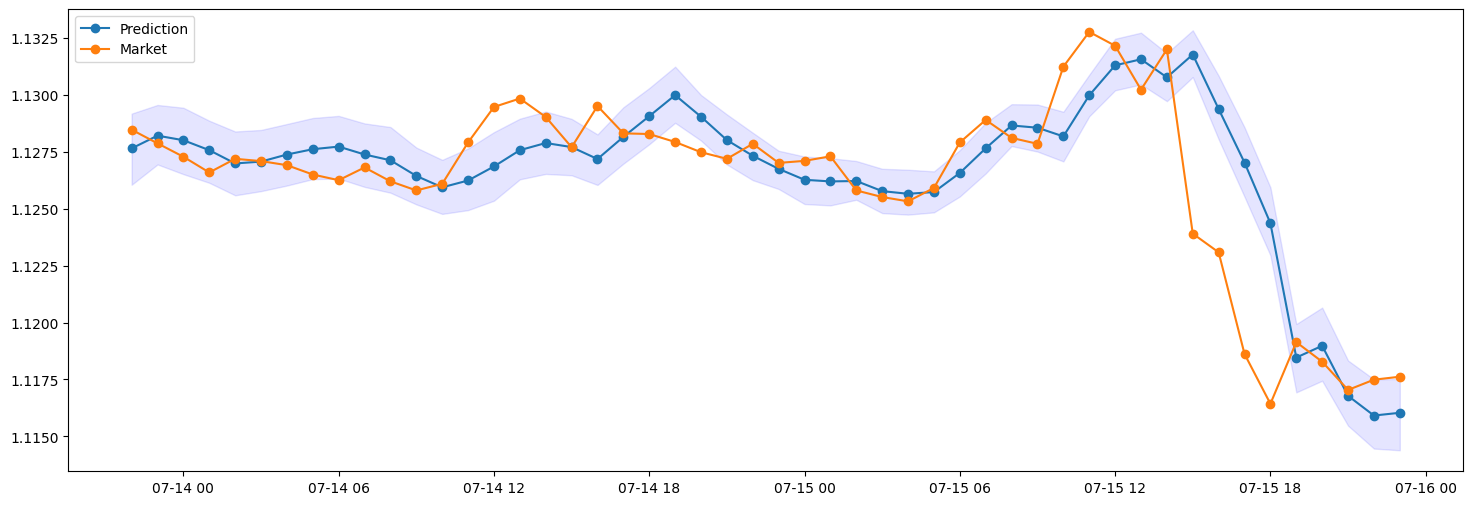

In [ ]:
from matplotlib import pyplot as plt
x1 = 200
x2 = 250
plt.figure(figsize=(18,6))
plt.plot(df['ds'].iloc[x1:x2],df['yhatlow'].iloc[x1:x2], label="Prediction", marker='o')
plt.fill_between(df['ds'].iloc[x1:x2], df['yhat'].iloc[x1:x2], df['yhathigh'].iloc[x1:x2], color='b', alpha=.1)
plt.plot(df['ds'].iloc[x1:x2], df['y'].iloc[x1:x2], label = "Market", marker='o')
plt.legend(loc="upper left")


In [ ]:
from tqdm import tqdm
backcandles=100
frontpredictions=4

prophetsignal = [0 for i in range(len(df))]

for row in tqdm(range(backcandles, len(df)-frontpredictions)):
    prophetsignal[row] = prophet_signal(df, row, backcandles, frontpredictions=1, diff_limit=0.005)

df["prophet_signal"] = prophetsignal

  0%|          | 0/896 [00:00<?, ?it/s]20:35:34 - cmdstanpy - INFO - Chain [1] start processing
20:35:35 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 1/896 [00:00<10:20,  1.44it/s]20:35:35 - cmdstanpy - INFO - Chain [1] start processing
20:35:35 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 2/896 [00:01<07:11,  2.07it/s]20:35:36 - cmdstanpy - INFO - Chain [1] start processing
20:35:36 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 3/896 [00:01<06:19,  2.35it/s]20:35:36 - cmdstanpy - INFO - Chain [1] start processing
20:35:36 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 4/896 [00:01<06:01,  2.47it/s]20:35:36 - cmdstanpy - INFO - Chain [1] start processing
20:35:36 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 5/896 [00:02<05:47,  2.56it/s]20:35:37 - cmdstanpy - INFO - Chain [1] start processing
20:35:37 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 6/896 [00:02<05:30,  2.69it/s]2

In [ ]:
df.reset_index(inplace=True, drop=True)

In [ ]:
df[(df['prophet_signal']==1)].count()

ds                894
open              894
high              894
low               894
close             894
volume            894
RSI               894
y                 894
prophet_signal    894
pointpos          894
dtype: int64

In [ ]:
df[df['prophet_signal']==1]

,ds,open,high,low,close,volume,RSI,y,prophet_signal,pointpos
100,2003-07-07 18:00:00,1.13216,1.13327,1.13122,1.13215,1.504914e+08,12.673971,1.13215,1,1.13337
101,2003-07-07 19:00:00,1.13206,1.13261,1.13143,1.13216,1.047805e+08,12.762497,1.13216,1,1.13271
102,2003-07-07 20:00:00,1.13238,1.13318,1.13195,1.13222,6.266590e+07,13.337541,1.13222,1,1.13328
103,2003-07-07 21:00:00,1.13177,1.13285,1.13122,1.13157,2.998560e+07,12.373612,1.13157,1,1.13295
104,2003-07-07 22:00:00,1.13115,1.13171,1.13080,1.13145,2.753750e+07,12.196093,1.13145,1,1.13181
...,...,...,...,...,...,...,...,...,...,...
991,2003-08-28 02:00:00,1.08570,1.08594,1.08401,1.08512,3.108810e+07,39.243622,1.08512,1,1.08604
992,2003-08-28 03:00:00,1.08516,1.08548,1.08466,1.08488,3.185470e+07,38.284391,1.08488,1,1.08558
993,2003-08-28 04:00:00,1.08512,1.08584,1.08476,1.08503,3.324850e+07,39.296063,1.08503,1,1.08594
994,2003-08-28 05:00:00,1.08480,1.08596,1.08478,1.08566,3.190050e+07,43.536862,1.08566,1,1.08606


In [ ]:
import numpy as np
def pointpos(x):
    if x["prophet_signal"]==1:
        return x['high']+1e-4
    elif x["prophet_signal"]==2:
        return x['low']-1e-4
    else:
        return np.nan

df['pointpos'] = df.apply(lambda row: pointpos(row), axis=1)

In [ ]:
dfpl = df
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['open'],
                high=dfpl['high'],
                low=dfpl['low'],
                close=dfpl['close'])])

fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
    paper_bgcolor='black',
    plot_bgcolor='black')
fig.update_xaxes(gridcolor='black')
fig.update_yaxes(gridcolor='black')
fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                marker=dict(size=8, color="MediumPurple"),
                name="Signal")
fig.show()

In [ ]:
from neuralprophet import NeuralProphet
def neural_prophet_signal(df, l, backcandles, frontpredictions, diff_limit):
    dfsplit = copy.deepcopy(df[l-backcandles:l+1][["ds", "y"]])
    model=NeuralProphet()
    model.fit(dfsplit) #the algo runs at the closing time of the current candle which is included in the fit
    future = model.make_future_dataframe(df=dfsplit, periods=frontpredictions)
    print(future)
    forecast = model.predict(future)
    #forecast = model.predict(df.iloc[l+1:l+frontpredictions,:-1]) #prediction start from next candle
    model.set_plotting_backend("plotly")
    #fig = model.plot(forecast)
    if(forecast.yhat1.mean()-df[l-backcandles:l+1].close.iat[-1]<diff_limit):
        return 1
    elif(forecast.yhat1.mean()-df[l-backcandles:l+1].close.iat[-1]>diff_limit):
        return 2
    else:
        return 0
#neural_prophet_signal(df, 200, 100, frontpredictions=5, diff_limit=0.002)